In [1]:
import torch
import cv2
import onnxruntime as ort
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from utils.util import full_frame_preprocess, full_frame_postprocess, crop_roi_image

def letterbox(im, new_shape=(320, 320), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

c:\Users\User\miniconda3\envs\test\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [5]:
weight_path = "../data/models/YoloV7_Tiny.onnx"
provider = ['CPUExecutionProvider']
gesture = "call"
threshold = 0.5

In [6]:
session = ort.InferenceSession(weight_path, providers=provider)

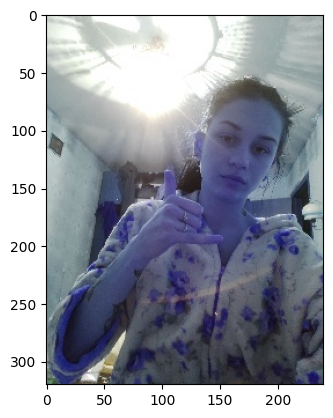

In [27]:
image_file = os.listdir(f"../data/train/{gesture}/")[3]
image = cv2.imread(f"../data/train/{gesture}/{image_file}")

#show image
plt.imshow(image)


In [52]:
outname=[i.name for i in session.get_outputs()]
image_output, ratio, dwdh = full_frame_preprocess(image, auto=False)

In [53]:
image_output.shape

(1, 3, 320, 320)

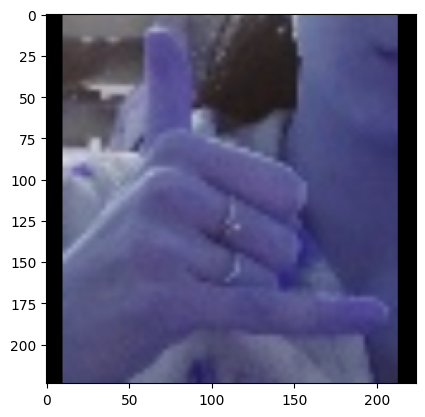

In [54]:
out = session.run(outname, {'images': image_output/255})[0]
bbox, score = full_frame_postprocess(out, ratio, dwdh, threshold)
cropped_image = crop_roi_image(image, bbox, (224, 224))
# x1, y1, x2, y2 = bbox
# crop_image = image[y1:y2, x1:x2]
plt.imshow(cropped_image)

# Gesture Detection

In [55]:
model_path = r"output\HaGRID_Test\with_scheduler\gesture_model.onnx"
hand_gesture_model = ort.InferenceSession(model_path, providers=provider)

In [56]:
#convert image to float
cropped_image = cropped_image.astype(np.float32)
#resize to (1, 3, 224, 224)
cropped_image = cropped_image.transpose((2, 0, 1))
cropped_image = np.expand_dims(cropped_image, 0)
cropped_image = np.ascontiguousarray(cropped_image)
cropped_image.shape

(1, 3, 224, 224)

In [59]:

gesture_outname=[i.name for i in hand_gesture_model.get_outputs()]

In [60]:
out = hand_gesture_model.run(gesture_outname, {'input.1': cropped_image/255})[0]

In [62]:
out.argmax()

0